# Project #3: Graph Databases/Neo4j
**Implementation Report**

Big Data Management Systems (Associate Prof. Damianos Chatziantoniou)\
Theodoros Plessas, 8160192 (t8160192@aueb.gr)

## 1. Introduction
Neo4j is a graph database management system, representing data as nodes and edges (relationships). Additionally, each node/edge may be characterized by zero or more properties, secondary data relevant to them. As relationships between nodes are given explicit importance (in comparison to relational databases) higher performance is achieved when data is modeled and stored using a network structure.

In this report I demonstrate proficiency in using Neo4j by importing the ["Social Network: MOOC User Action Dataset"](https://snap.stanford.edu/data/act-mooc.html) into a graph database and retrieving data using [Cypher](https://en.wikipedia.org/wiki/Cypher_(query_language)), a query language designed around the specific characteristics of graph databases.

## 2. Installing Neo4j and retrieving dataset

This assignment was carried out on a personal Fedora 33 machine.

[Neo4j Community Edition 4.2.6](https://neo4j.com/download-center/#community) was downloaded from the website [as a tarball](https://neo4j.com/docs/operations-manual/current/installation/linux/tarball/) and extracted to my home directory in order to make configuration and cleanup easier. I then started the server and set a custom password from the browser interface:

    tar -xf neo4j-community-4.2.6-unix.tar.gz
    cd neo4j-community-4.2.6/
    ./bin/neo4j console
    
The dataset tarball was downloaded and extracted in the project directory:

    wget https://snap.stanford.edu/data/act-mooc.tar.gz
    tar -xf act-mooc.tar.gz

## 3. Importing data into Neo4j

The dataset was imported into Neo4j programatically using a Python script and the [Neo4j Python Driver 4.2](https://neo4j.com/docs/api/python-driver/current/), which should be available in your environment for this script to execute successfully (as well as the dataset itself, check the previous section for downloading instructions). Make sure before execution that the "neo4j" database is wiped of all data (`MATCH (n) DETACH DELETE (n)`). 

The script parses each line of the three files, building two sets and a dictionary with all the data to be imported to Neo4j in advance. This allows using only CREATE clauses in Cypher, as the specification of the assignment suggested. An unguided personal implementation would make use of MERGE and SET clauses for nodes/relationships and properties respectively, with each piece of data being imported as the files are being iterated upon.

In [13]:
from neo4j import GraphDatabase

# storage for data
users = set()
targets = set()
actions = {}

# iterate upon each file, extract data and store function
def import_data():
    file = open('act-mooc/mooc_actions.tsv', 'r')
    next(file) # skip column names
    for line in file:
        line = line.strip() # Remove newline character
        data = line.split('\t')

        users.add(data[1])
        targets.add(data[2])
        actions[data[0]] = { 'timestamp' : data[3],
                             'user' : data[1],
                             'target' : data[2] }

    file = open('act-mooc/mooc_action_features.tsv', 'r')
    next(file) # skip column names
    for line in file:
        line = line.strip() # Remove newline character
        data = line.split('\t')

        actions[data[0]].update( { 'feature-0' : data[1],
                                   'feature-1' : data[2],
                                   'feature-2' : data[3],
                                   'feature-3' : data[4] } )

    file = open('act-mooc/mooc_action_labels.tsv', 'r')
    next(file) # skip column names
    for line in file:
        line = line.strip() # Remove newline character
        data = line.split('\t')

        actions[data[0]]['label'] = data[1]

# create node and relationship functions
def create_user_node(tx, userid):
    tx.run("CREATE (n:user{userid:$userid})", userid = userid)
    
def create_target_node(tx, targetid):
    tx.run("CREATE (n:target{targetid:$targetid})", targetid = targetid)
    
def create_action(tx, userid, targetid, actionid, timestamp, feature0, feature1, feature2, feature3, label):
    tx.run("MATCH (u:user) WHERE u.userid = $userid "
           "MATCH (t:target) WHERE t.targetid = $ targetid "
           "CREATE (u)-[r:action {actionid: $actionid, timestamp:$timestamp, feature0:$feature0, feature1:$feature1, feature2:$feature2, feature3:$feature3, label:$label}]->(t)",
           userid = userid, targetid = targetid, actionid = actionid, timestamp = timestamp,
           feature0 = feature0, feature1 = feature1, feature2 = feature2,
           feature3 = feature3, label = label)

import_data()

# initialize neo4j driver
# enter your own server url-username-password combo
neo4j = GraphDatabase.driver('neo4j://localhost:7687', auth=("neo4j", "neo5j"))

with neo4j.session() as session:
    for userid in users:
        session.write_transaction(create_user_node, userid)
        
    for targetid in targets:
        session.write_transaction(create_target_node, targetid)
        
    for action in actions:
        userid = actions[action]['user']
        targetid = actions[action]['target']
        timestamp = actions[action]['timestamp']
        feature0 = actions[action]['feature-0']
        feature1 = actions[action]['feature-1']
        feature2 = actions[action]['feature-2']
        feature3 = actions[action]['feature-3']
        # Not all actions have labels (some have duplicates in the dataset)
        # If so use -1 to signify lack
        try:
            label = actions[action]['label']
        except KeyError:
            label = -1
        session.write_transaction(create_action, userid, targetid, action, timestamp, feature0, feature1, feature2, feature3, label)
        
neo4j.close()

After execution all data should be available in the default Neo4j database, as can be seen below:

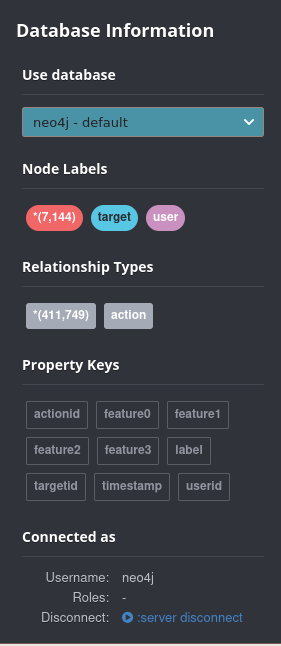

As an aside, I found usage of the API to be rather cumbersome, not to mention slow; full execution of the above script on my machine took a staggering 59 minutes. This might be due to a problem specific to my environment (which is not out of the question; I am using the PassMark equivalent of a Core 2 Quad Q9400 from 2008) or might signify performance issues with the driver itself.

## 4. Executing Cypher queries

All queries of this section were executed in Neo4j's browser environment, with benchmarking results also coming from there.

### 4.1. "Show a small portion of your graph database (screenshot)"

    MATCH (u:user)-[a:action]->(t:target) RETURN u,a,t LIMIT 300
    > Started streaming 300 records after 2 ms and completed after 31 ms.
    
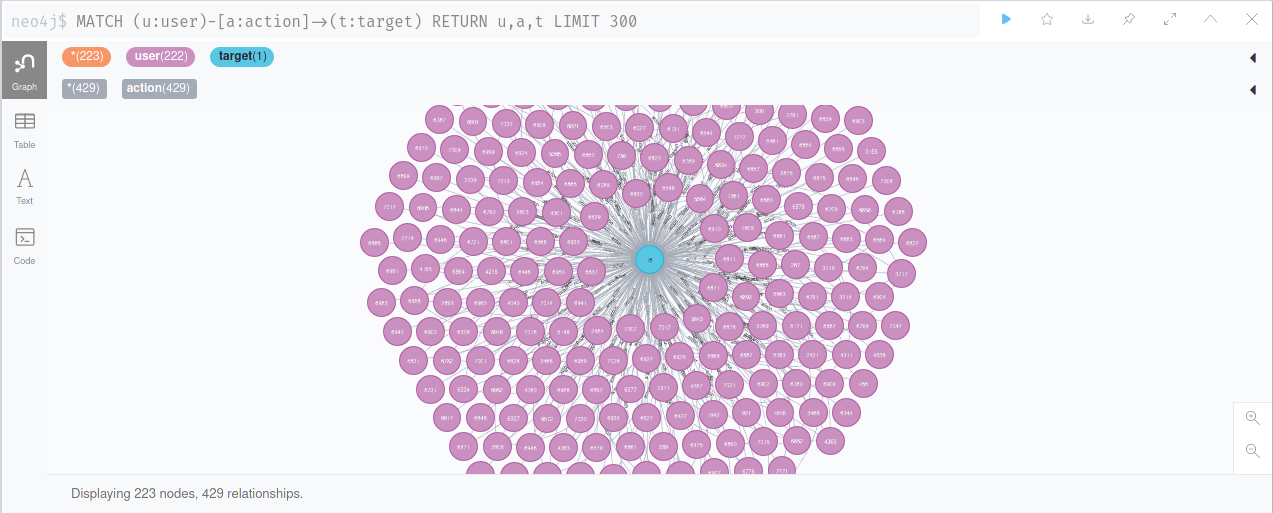

As may be seen above, only one target appears, with all users and their actions clustered around it. This is normal, as there is a huge discrepancy between the number of targets (only 97) and users (7,047).

### 4.2. "Count all users, count all targets, count all actions"

    MATCH (u:user)
    WITH count(u) as count
    RETURN 'users' as label, count
    UNION ALL
    MATCH ()-[a:action]->()
    WITH count(a) as count
    RETURN 'actions' as label, count
    UNION ALL
    MATCH (t:target)
    WITH count(t) as count
    RETURN 'targets' as label, count
    > Started streaming 3 records in less than 1 ms and completed in less than 1 ms.
    
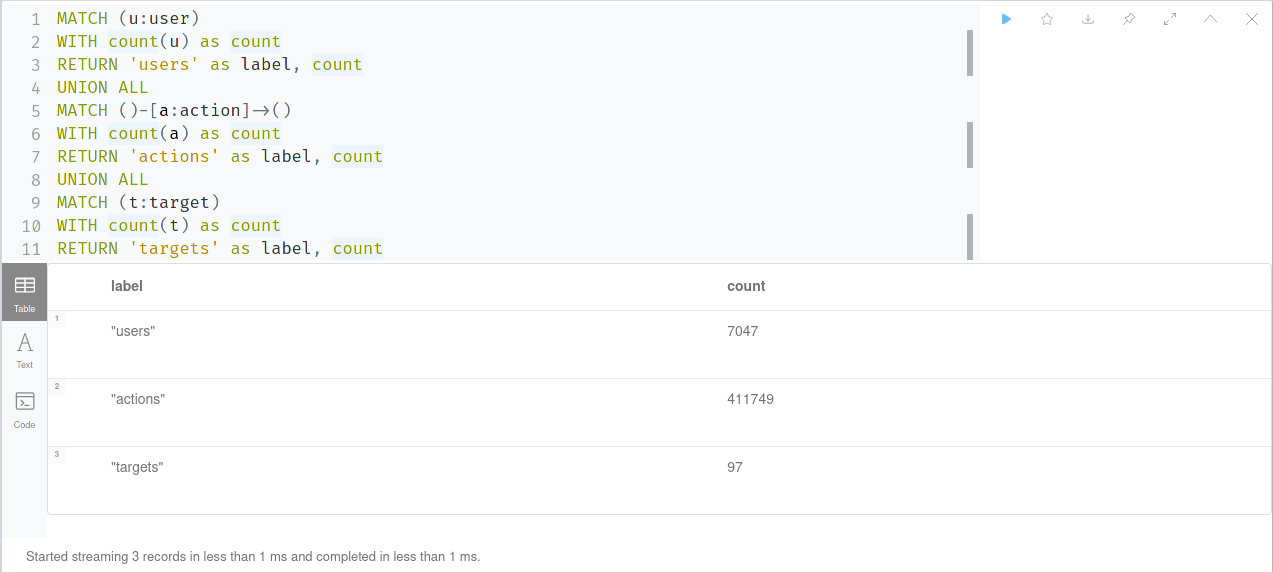

### 4.3. "Show all actions (actionID) and targets (targetID) of a specific user (choose one)"

    MATCH (u:user {userid:'369'})-[a:action]->(t:target)
    RETURN a.actionid, t.targetid
    > Started streaming 15 records after 1 ms and completed after 7 ms.
    
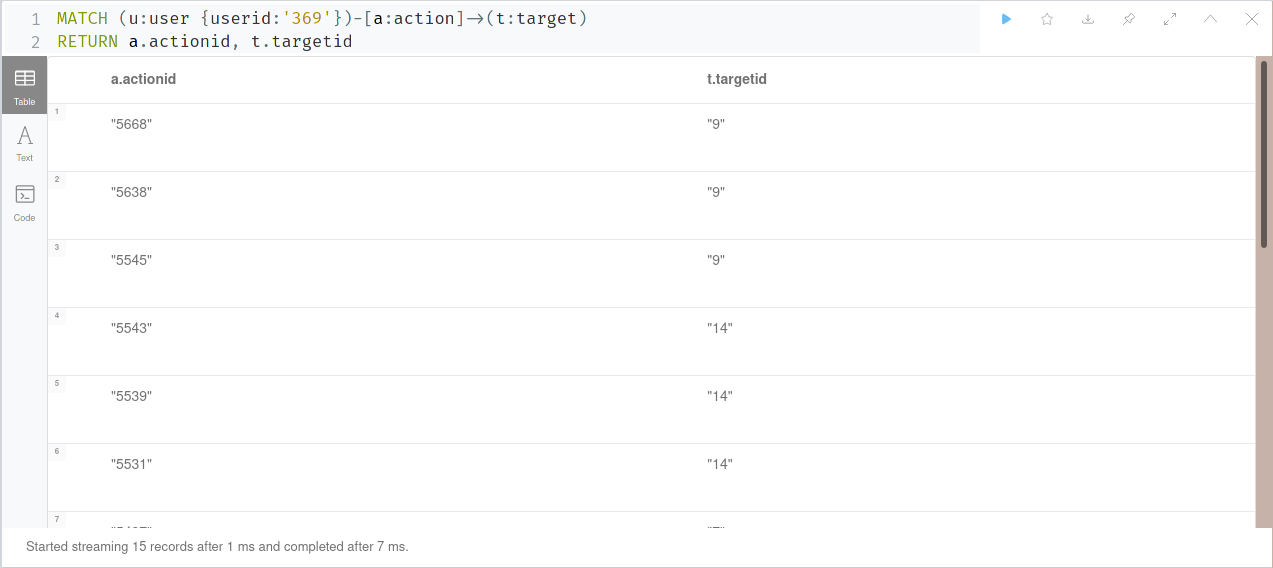

### 4.4. "For each user, count his/her actions"

    MATCH (u:user)-[a:action]->(t:target)
    RETURN u.userid, count(a) as actions
    > Started streaming 7047 records after 2 ms and completed after 3 ms, displaying first 1000 rows.
    
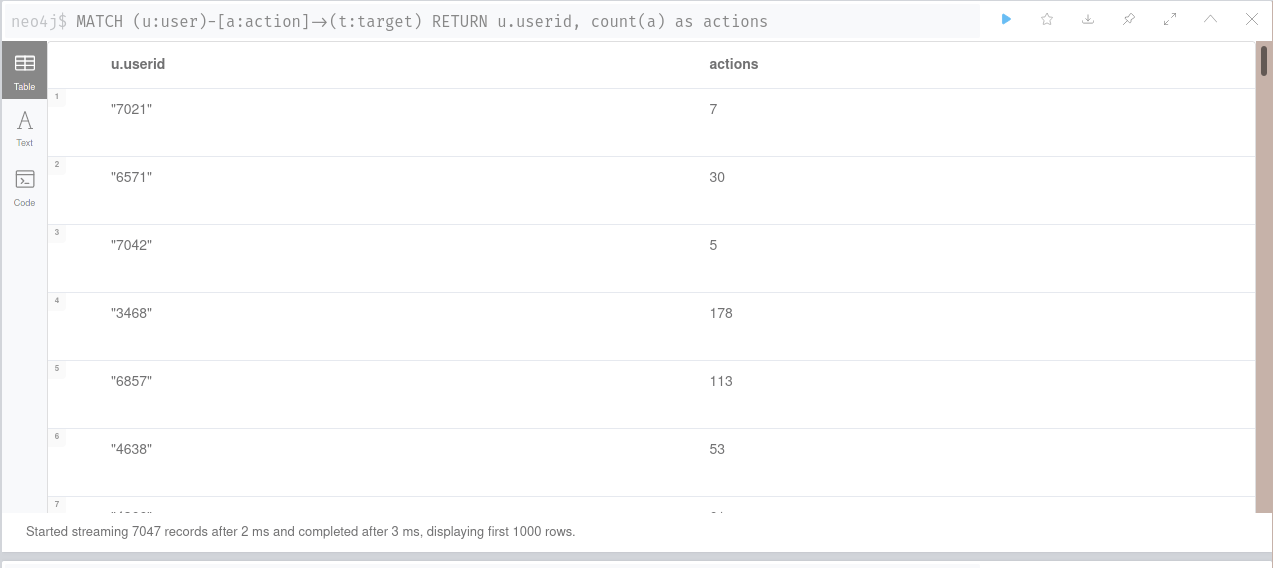

### 4.5. "For each target, count how many users have done it"

    MATCH (t:target)<-[a:action]-(u:user)
    RETURN t.targetid, count(u) as users
    > Started streaming 97 records after 2 ms and completed after 1946 ms.
    
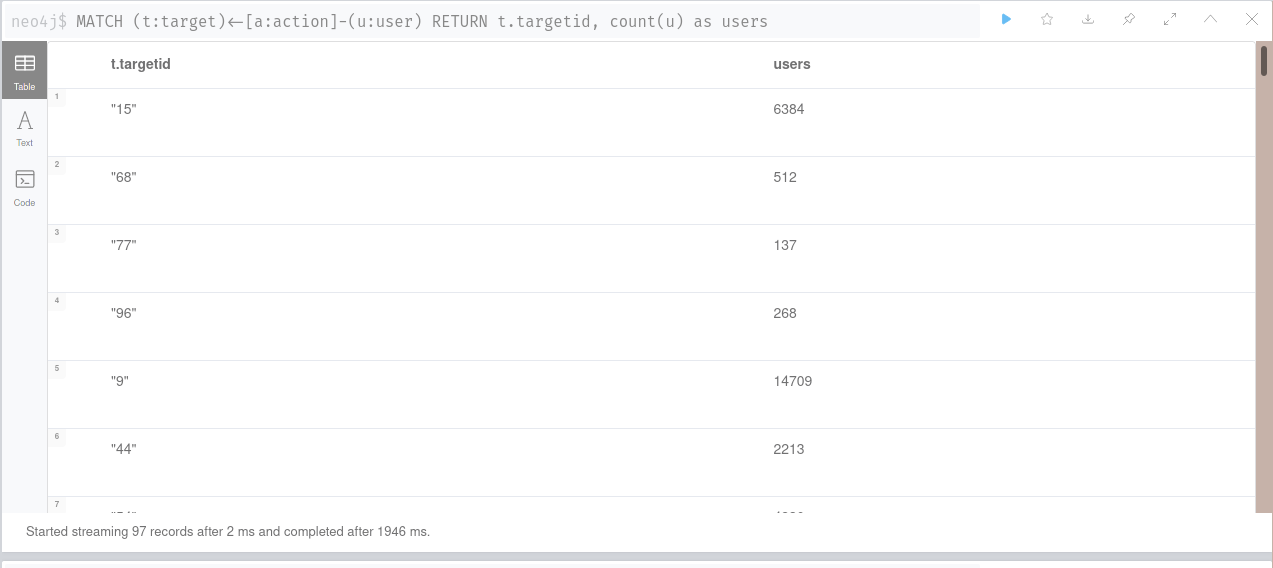

### 4.6. "Count the average actions per user"

    MATCH (u:user)
    WITH u, size((u)--()) as actions
    RETURN avg(actions) as averageactions
    > Started streaming 1 records after 1 ms and completed after 9 ms.
    
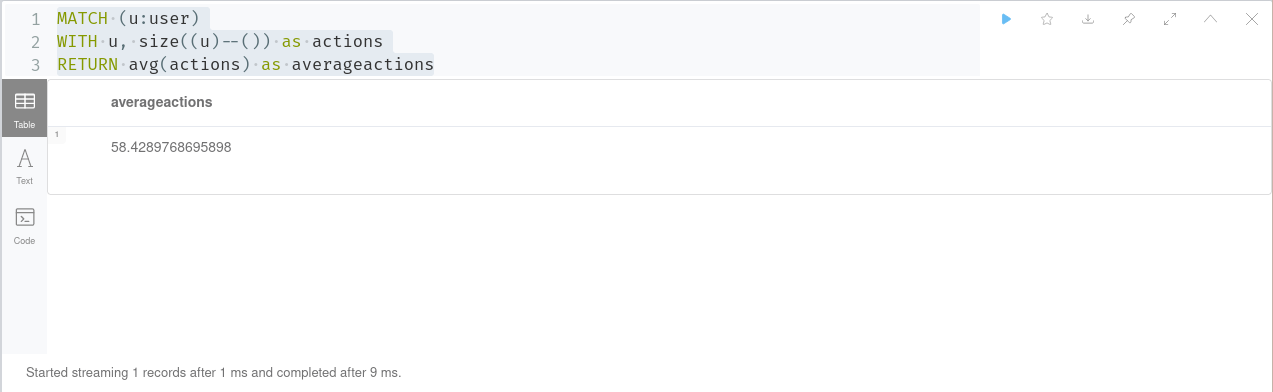

### 4.7. "Show the userID and the targetID, if the action has positive Feature2"

    MATCH (u:user)-[a:action]->(t:target)
    WHERE toFloat(a.feature2) > 0
    RETURN u.userid, t.targetid
    > Started streaming 287960 records in less than 1 ms and completed after 23 ms, displaying first 1000 rows.
    
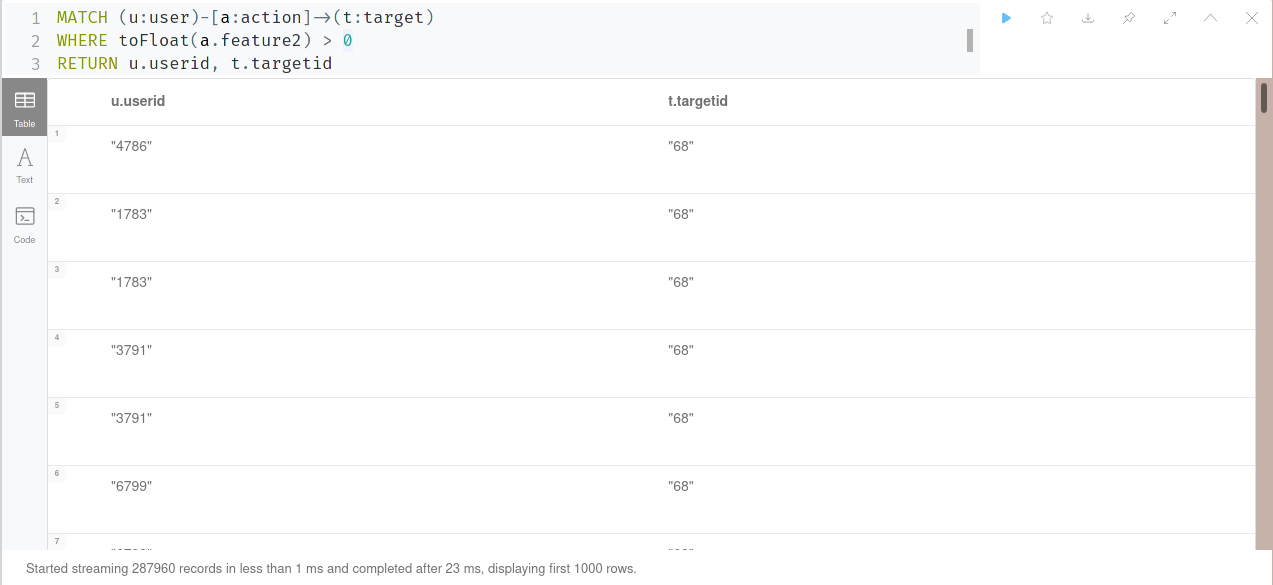

### 4.8. "For each targetID, count the actions with label '1'"

    MATCH (t:target)<-[a:action]-(u:user)
    WHERE a.label = '1'
    RETURN t.targetid, count(a)
    > Started streaming 85 records after 2 ms and completed after 1466 ms.
    
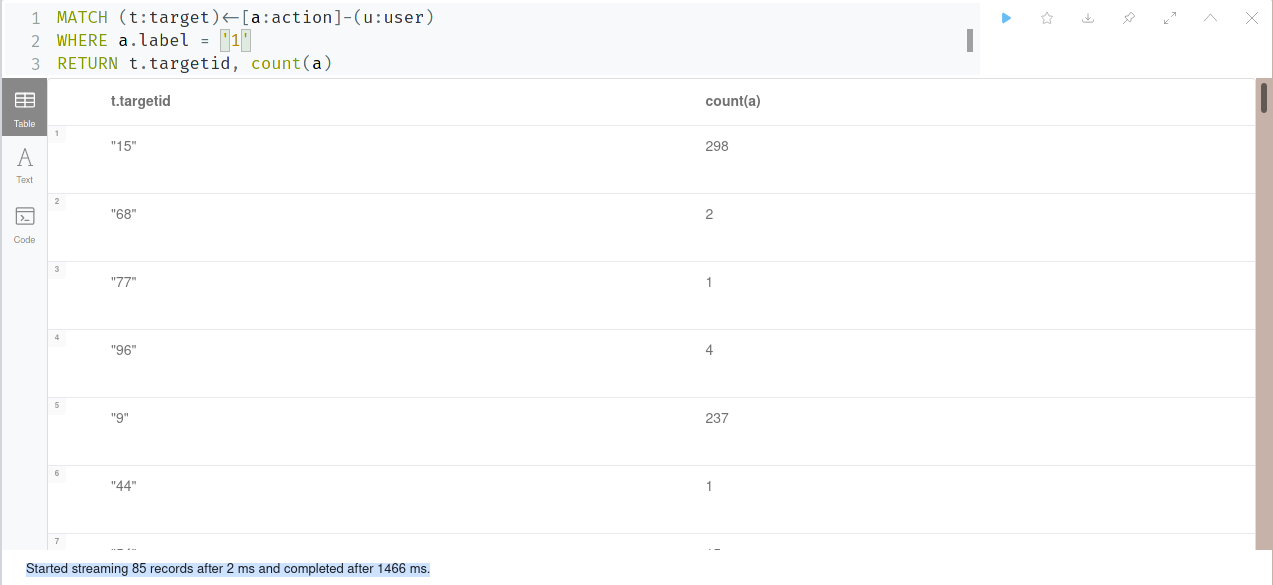

## 5. Conclusion

Through this assignment I acquired first-hand experience in creating, manipulating and accessing a graph database using real-life data, gaining a basic understanding of the possible applications and high performance such databases can support and offer respectively (barring the data import part, that is, though I am still suspicious I might have been at fault for that in some way). Execution of most queries can be measured in double-digit milliseconds, which is undoubtedly a radical improvement over the relational databases of old.

I fully expect to be revisiting Neo4j in the future, most probably in a data analysis-related workplace role.

## 6. Further resources used

`[1]` [The Neo4j Cypher Manual v4.2](https://neo4j.com/docs/cypher-manual/current/)  
`[2]` ["How can I calculate the average number of relationships each node has in neo4j?"](https://stackoverflow.com/questions/61148329/how-can-i-calculate-the-average-number-of-relationships-each-node-has-in-neo4j)  
`[3]` [Fast counts using the count store](https://neo4j.com/developer/kb/fast-counts-using-the-count-store/)  
`[4]` [Neo4j Tutorial](https://www.quackit.com/neo4j/tutorial/)  